"Пассажиры автобуса"

Нейронная сеть для решения задачи классификации пассажиров на входящих и выходящих.

### Загрузка данных


In [ ]:
# методы для отрисовки изображений
from PIL import Image
# Для отрисовки графиков
import matplotlib.pyplot as plt
# Для генерации случайных чисел
import random
# Библиотека работы с массивами
import numpy as np
# Для работы с файлами
import os
# импортируем модуль для загрузки данных
import gdown
# для разделения выборок
from sklearn.model_selection import train_test_split
# для создания сети
from tensorflow.keras.models import Sequential
# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, SpatialDropout2D
# для работы с изображениями
from tensorflow.keras.preprocessing import image
# оптимизатор
from tensorflow.keras.optimizers import Adam
# модуль для отсчета времени
import time

In [ ]:
# загрузка датасета, укажем путь к базе в Google Drive, база в виде .zip-архива
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l4/bus.zip', None, quiet=True)

# Распакуем архив в директорию 'content/bus'
!unzip -q "bus.zip" -d /content/bus

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/bus/'

# Получение списка папок, находящемуся по адресу в скобках
os.listdir(IMAGE_PATH)

['Входящий', 'Выходящий']

In [ ]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Входящий', 'Выходящий']


In [ ]:
# Получения списка файлов для каждого класса

for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

Входящий : ['01948.jpg', '01108.jpg', '05994.jpg', '00118.jpg', '03140.jpg', '03387.jpg', '05833.jpg', '04369.jpg', '00816.jpg', '04802.jpg', '01893.jpg', '03367.jpg', '05357.jpg', '00279.jpg', '00102.jpg', '06304.jpg', '04229.jpg', '01009.jpg', '00077.jpg', '00489.jpg', '05211.jpg', '04552.jpg', '03395.jpg', '03691.jpg', '01480.jpg', '03623.jpg', '00172.jpg', '03460.jpg', '01383.jpg', '03911.jpg', '00041.jpg', '00778.jpg', '01696.jpg', '02751.jpg', '05526.jpg', '00796.jpg', '00692.jpg', '06300.jpg', '03095.jpg', '04546.jpg', '04593.jpg', '03783.jpg', '01991.jpg', '01517.jpg', '05381.jpg', '01054.jpg', '01590.jpg', '02668.jpg', '00621.jpg', '04772.jpg', '03476.jpg', '04225.jpg', '00880.jpg', '03031.jpg', '06234.jpg', '03994.jpg', '01759.jpg', '05852.jpg', '03823.jpg', '03904.jpg', '00078.jpg', '01938.jpg', '02404.jpg', '05901.jpg', '01906.jpg', '05144.jpg', '02053.jpg', '04011.jpg', '00072.jpg', '01985.jpg', '05374.jpg', '02462.jpg', '03388.jpg', '00501.jpg', '04370.jpg', '04264.jpg', 

Отобразим визуально для примера по одному изображению из каждого класса (при помощи функции `.imshow()` из модуля `matplotlib.pyplot`):

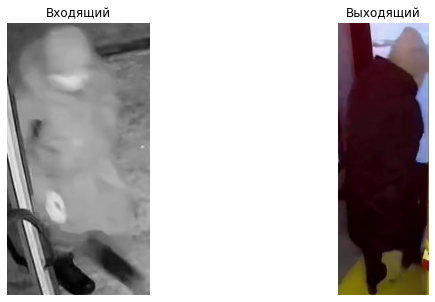

In [ ]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))

    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [ ]:
input = len(os.listdir('/content/bus/Входящий'))
output = len(os.listdir('/content/bus/Выходящий'))

print(f'Входящие: {input}')
print(f'Выходящие: {output}')

Входящие: 6485
Выходящие: 2596


In [ ]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса Входящий составляет 6485 фото
Размер класса Выходящий составляет 2596 фото

Общий размер базы для обучения: 9081


In [ ]:
from tensorflow.keras.preprocessing import image

x_data = []

base_path = '/content/bus/Входящий/'

for f in os.listdir(base_path):
  x_data.append(image.img_to_array(image.load_img(base_path+f, target_size=(64,32))))


print(np.array(x_data).shape)

(6485, 64, 32, 3)


In [ ]:
# Задание высоты и ширины загружаемых изображений
IMG_HEIGHT = 32
IMG_WIDTH = 64

# Пустой список для данных изображений
data_images = []

for file_name in data_files:
    # Открытие и смена размера изображения
    img = Image.open(file_name).resize((IMG_HEIGHT, IMG_WIDTH)).convert("L")
    img_np = np.array(img)                # Перевод в numpy-массив
    data_images.append(img_np)            # Добавление изображения в виде numpy-массива к общему списку

x_data = np.array(data_images).reshape(-1,32,64,1)            # Перевод общего списка изображений в numpy-массив
y_data = np.array(data_labels)            # Перевод общего списка меток класса в numpy-массив

print(f'В массив собрано {len(data_images)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_data.shape}')

В массив собрано 9081 фотографий следующей формы: (64, 32)
Общий массив данных изображений следующей формы: (9081, 32, 64, 1)
Общий массив меток классов следующей формы: (9081,)


In [ ]:
# Нормированние массива изображений
x_data = x_data / 255.

### Модель

In [ ]:
# задаем желаемый размер изображениям

img_height = 32 # Высота
img_width = 64 # Ширина
chanels = 1 # Количество каналов

input_shape = (img_height, img_width, chanels)

Количество фильтров возрастает, а размер изображения убывает. Это один из действенных способов классифицировать изображения сверточными сетями.

Любое изображение с точки зрения математики представляет собой совокупность правил взаимного расположения элементов. Соотв. чем больше фильтров ищут признаки, тем выше шанс.

In [ ]:
model = Sequential()

# 1
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(input_shape)))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.5))

# 1
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.5))


model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# 2
# model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())
# model.add(SpatialDropout2D(0.5))

# # 2
# model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(SpatialDropout2D(0.5))

# # 2
# model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())
# model.add(SpatialDropout2D(0.5))

# # 3
# model.add(BatchNormalization())
# model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))                             # 9*6
# model.add(SpatialDropout2D(0.3))

# # 4
# model.add(BatchNormalization())
# model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))                             # 3*2
# model.add(SpatialDropout2D(0.3))

# # 5
# model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# model.add(SpatialDropout2D(0.3))

model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='elu'))
model.add(Dense(2, activation='softmax')) # Выходной полносвязный слой с количеством нейронов 1, т.к. бинарная классификация


Epoch 1/200
15/15 [==============================] - 21s 487ms/step - loss: 0.6645 - accuracy: 0.7200 - val_loss: 1.1793 - val_accuracy: 0.0000e+00
Epoch 2/200
15/15 [==============================] - 3s 229ms/step - loss: 0.4265 - accuracy: 0.8498 - val_loss: 1.6203 - val_accuracy: 0.0000e+00
Epoch 3/200
15/15 [==============================] - 3s 228ms/step - loss: 0.3803 - accuracy: 0.8683 - val_loss: 2.7456 - val_accuracy: 0.0000e+00
Epoch 4/200
15/15 [==============================] - 3s 229ms/step - loss: 0.3532 - accuracy: 0.8768 - val_loss: 2.6030 - val_accuracy: 0.0000e+00
Epoch 5/200
15/15 [==============================] - 3s 232ms/step - loss: 0.3393 - accuracy: 0.8811 - val_loss: 2.4413 - val_accuracy: 0.0000e+00
Epoch 6/200
15/15 [==============================] - 3s 230ms/step - loss: 0.3392 - accuracy: 0.8798 - val_loss: 2.5260 - val_accuracy: 0.0000e+00
Epoch 7/200
15/15 [==============================] - 3s 231ms/step - loss: 0.3261 - accuracy: 0.8853 - val_loss: 3.11

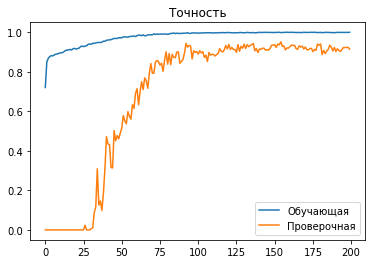

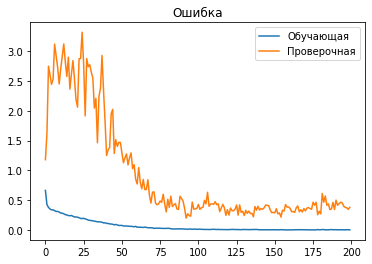

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

store = model.fit(x_data,
                  y_data,
                  shuffle=True,
                  batch_size=512,
                  epochs=200,
                  validation_split=0.2,
                  verbose=1)
plt.plot(store.history['accuracy'], label='Обучающая')
plt.plot(store.history['val_accuracy'], label='Проверочная')
plt.legend()
plt.title('Точность')
plt.show()
plt.plot(store.history['loss'], label='Обучающая')
plt.plot(store.history['val_loss'], label='Проверочная')
plt.legend()
plt.title('Ошибка')
plt.show()